## License 

Copyright 2017 - 2020 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

In [1]:
# TODO:
#   redo MGBM to use h2o grid search
#   redo PDP function to use h2o
#   only print comparison bar chart for best MGBM
#   ...

#### Python imports 

In [2]:
import h2o                                                        # import h2o python bindings to java server
from h2o.estimators.glm import H2OGeneralizedLinearEstimator      # for benchmark model
from h2o.grid.grid_search import H2OGridSearch                    # for benchmark model
from h2o.estimators.gbm import H2OGradientBoostingEstimator       # for GBM
import numpy as np                                                # array, vector, matrix calculations
import pandas as pd                                               # DataFrame handling
import shap                                                       # for consistent, signed variable importance measurements
import xgboost as xgb                                             # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

SEED = 12345
np.random.seed(SEED)                # set random seed for reproducibility

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\p\AppData\Local\Temp\tmppd81heaq
  JVM stdout: C:\Users\p\AppData\Local\Temp\tmppd81heaq\h2o_p_started_from_python.out
  JVM stderr: C:\Users\p\AppData\Local\Temp\tmppd81heaq\h2o_p_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,4 months and 26 days !!!
H2O cluster name:,H2O_from_python_p_6u4e3m
H2O cluster total nodes:,1
H2O cluster free memory:,3.539 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [5]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

#### Calculate Pearson correlation

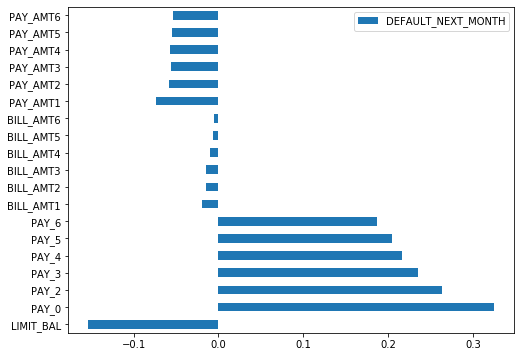

In [6]:
corr = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]
corr.columns = ['Pearson Correlation Coefficient']

# display correlation matrix as barchart
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1].plot(kind='barh', ax=ax_)

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


In [8]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    
    # define search criteria
    # i.e. over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts} 

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="binomial",
            lambda_search=True,
            seed=SEED),
        hyper_params=hyper_parameters)
    
    # run grid search
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # select best model from grid search
    return grid.get_grid()[0]

best_glm = glm_grid(X, y, h2o.H2OFrame(train), h2o.H2OFrame(test))
print('Best penalized GLM AUC: %.2f' % 
      best_glm.auc(valid=True))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Grid Build progress: |████████████████████████████████████████████████| 100%
Best penalized GLM AUC: 0.73


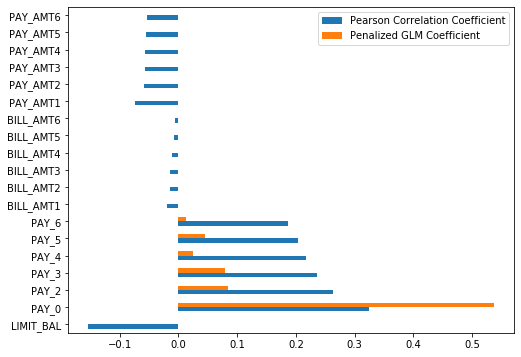

In [9]:
glm_coef = pd.DataFrame.from_dict(best_glm.coef(), orient='index', columns=['Penalized GLM Coefficient'])
corr_glm = pd.concat([corr,glm_coef.iloc[1:]], axis=1)

fig, ax_ = plt.subplots(figsize=(8, 6))
_ = corr_glm.plot(kind='barh', ax=ax_)

#### Train Monotonic XGBoost GBM classifier

In [10]:
def mgbm_grid(X, mc): 
    
    # define random grid search parameters
    hyper_parameters = {'ntrees':list(range(1, 500, 50)),
                        'max_depth':list(range(1, 20, 2)),
                        'sample_rate':[s/float(10) for s in range(1, 11)],
                        'col_sample_rate':[s/float(10) for s in range(1, 11)]}

    # define search strategy
    search_criteria = {'strategy':'RandomDiscrete',
                       'max_models':20,
                       'max_runtime_secs':600,
                       'seed': SEED}

    # initialize grid search
    gsearch = H2OGridSearch(H2OGradientBoostingEstimator,
                            hyper_params=hyper_parameters,
                            search_criteria=search_criteria)

    # execute training w/ grid search
    gsearch.train(x=X,
                  y=y,
                  monotone_constraints=mc,
                  training_frame=htrain,
                  validation_frame=htest,
                  stopping_rounds=5,
                  seed=SEED)
    
    
    mgbm_model = gsearch.get_grid()[0]

    return mgbm_model
    

In [11]:
#### initialize data structures needed to compare correlation coefficients,
# penalized glm coefficients, and MGBM Shapley values
# as features are added into the MGBM

# create a list of features to add into MGBM expectation
# list is ordered by correlation between X_j and y
abs_corr = corr.copy(deep=True)
abs_corr['Pearson Correlation Coefficient'] = corr['Pearson Correlation Coefficient'].abs()
X_selected = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
next_list = [name for name in list(abs_corr.sort_values(by='Pearson Correlation Coefficient',
                                                        ascending=False).index) if name not in X_selected]

# create a Pandas DataFrame to store new MGBM SHAP values
# for comparison to correlation and penalized gbm coefficients
abs_corr_glm_mgbm_shap = corr_glm.copy(deep=True).abs()
abs_corr_glm_mgbm_shap.columns = ['Absolute ' + name for name in abs_corr_glm_mgbm_shap.columns]
abs_corr_glm_mgbm_shap['Monotonic GBM Mean SHAP Value'] = 0

# init empty parallel lists to store results 
mgbm_models = []
corr_glm_mgbm_shap_coefs = []

#### train multiple MGBMs
# each time adding in the next most y-correlated feature
for j, name in enumerate(next_list):

    # create monotonicity contraints for the current model
    names = list(test[X_selected + [y]].corr()[y].index)[:-1]
    signs = list([int(i) for i in np.sign(test[X_selected + [y]].corr()[y].values[:-1])])
    mc = dict(zip(names, signs))

    # convert training and test data to h2o format
    htrain = h2o.H2OFrame(train[X_selected + [y]]) # necessary to ensure ordering of Shapley values matches X_selected
    htrain[y] = htrain[y].asfactor()               # ensure y is treated as binomial
    htest = h2o.H2OFrame(test[X_selected + [y]])
    
    # train model and calculate Shapley values
    mgbm_models.append(mgbm_grid(X_selected, mc))
    shap_values = mgbm_models[j].predict_contributions(htest).as_data_frame().values[:,:-1]
    
    # update Pandas dataframe with current model Shapley values
    col = pd.DataFrame({'Monotonic GBM Mean SHAP Value': 
                        list(np.abs(shap_values).mean(axis=0))}, index=X_selected)
    abs_corr_glm_mgbm_shap.update(col)
    corr_glm_mgbm_shap_coefs.append(abs_corr_glm_mgbm_shap.copy(deep=True)) # deep copy necessary
    
    # retrieve AUC and print progress
    auc_ = mgbm_models[j].auc(valid=True)
    print('Completed grid search %i/%i with AUC: %.2f ...\n' % (j+1, len(next_list), auc_))
      
    # add the next most y-correlated feature
    # for the next modeling iteration
    X_selected = X_selected + [next_list[j]]
    
print('Done.')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 1/13 with AUC: 0.74 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 2/13 with AUC: 0.76 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
Completed grid search 3/13 with AUC: 0.77 ...

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |████████████████████████████████

#### Plot results

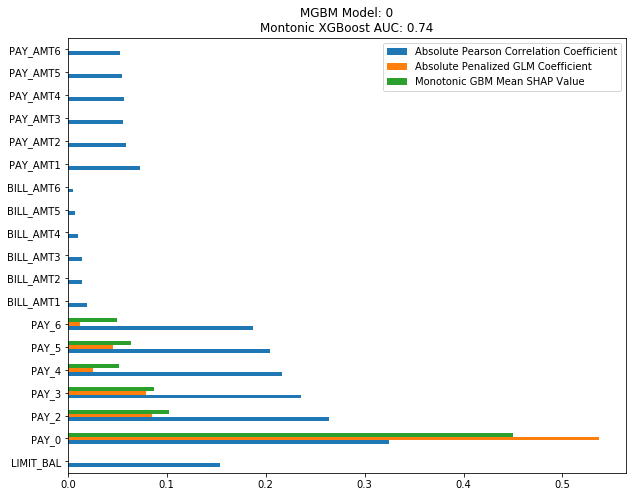

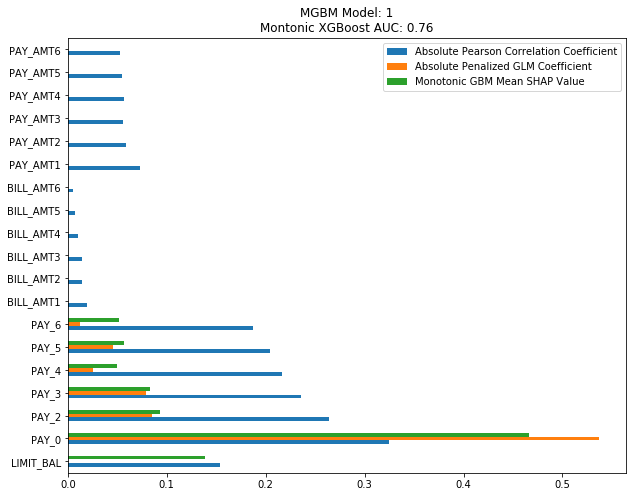

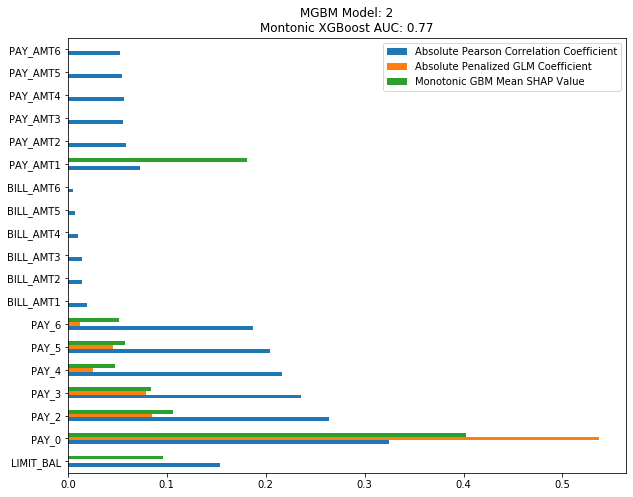

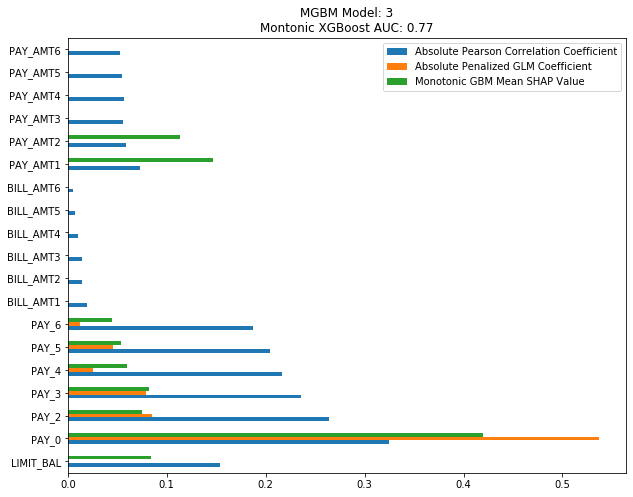

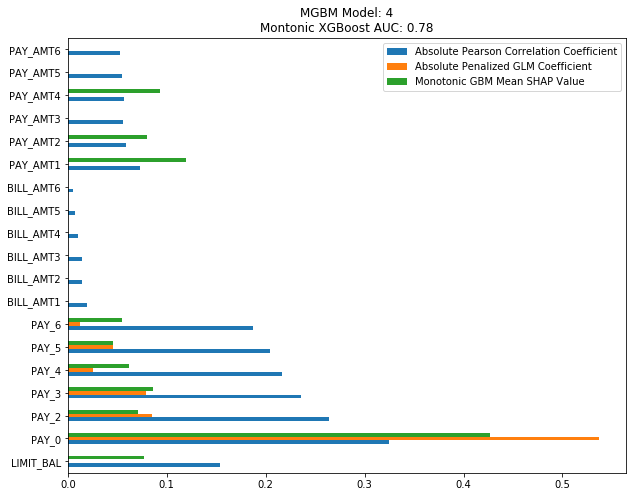

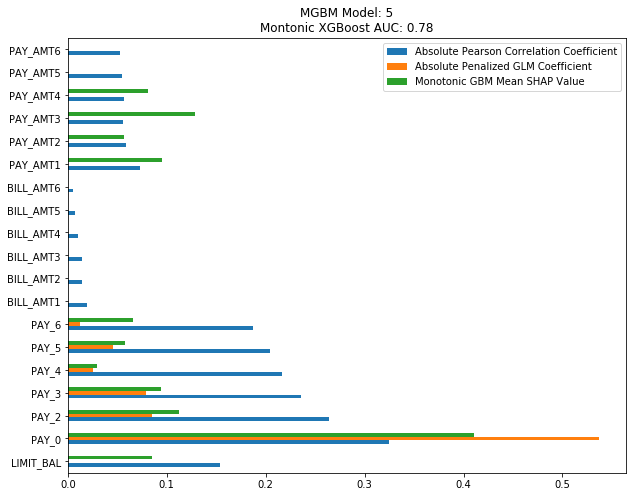

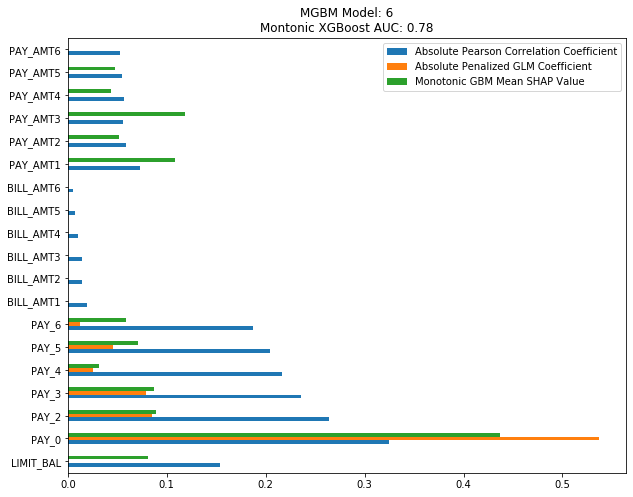

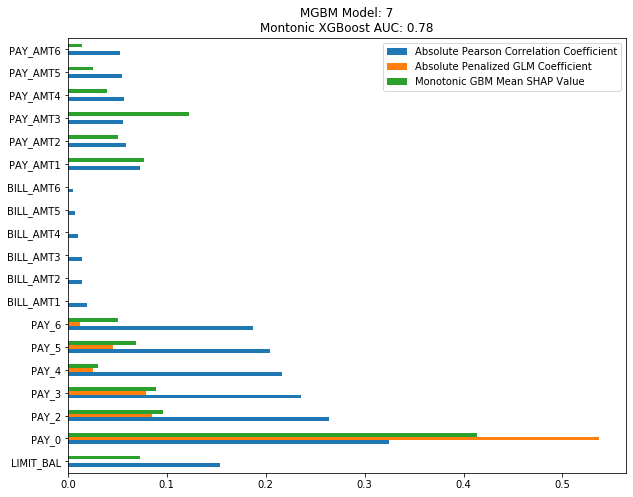

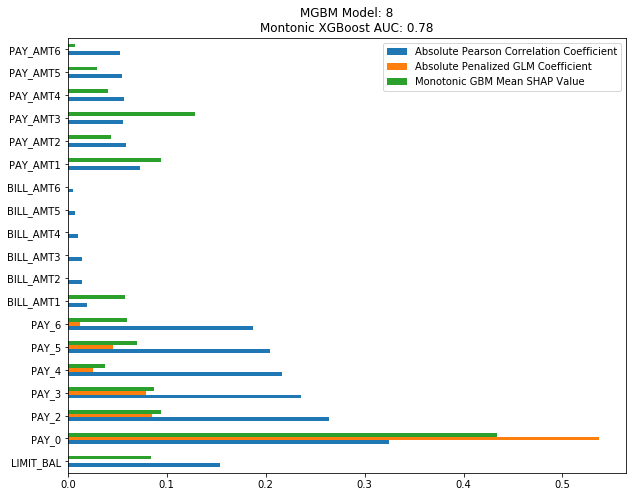

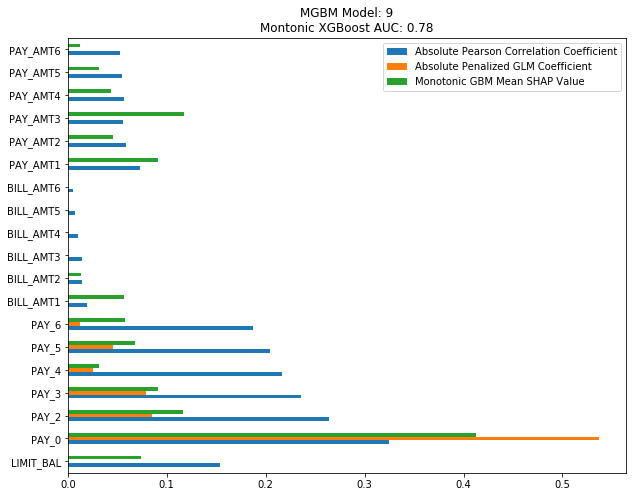

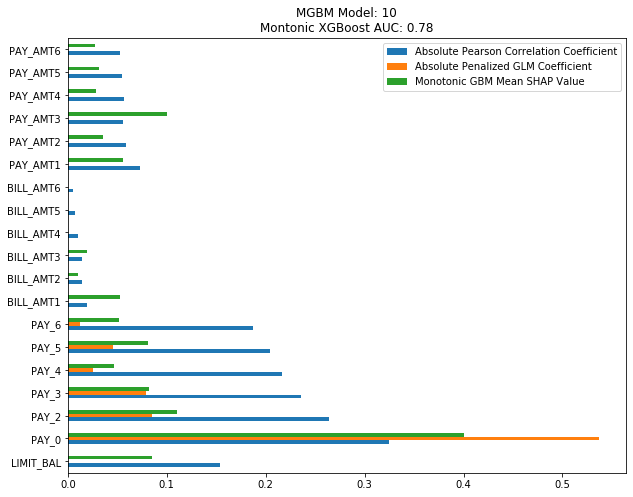

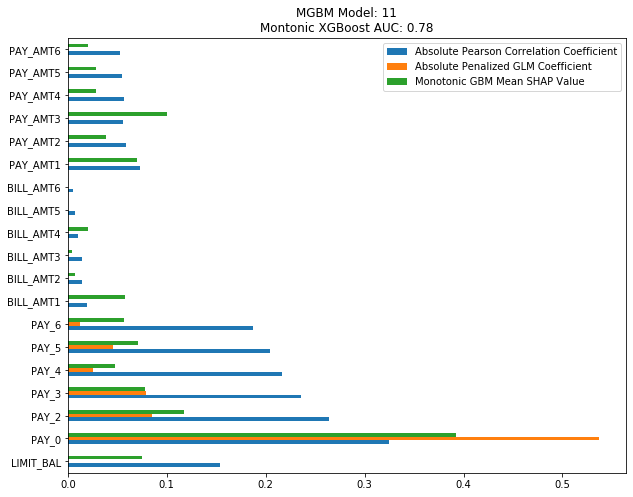

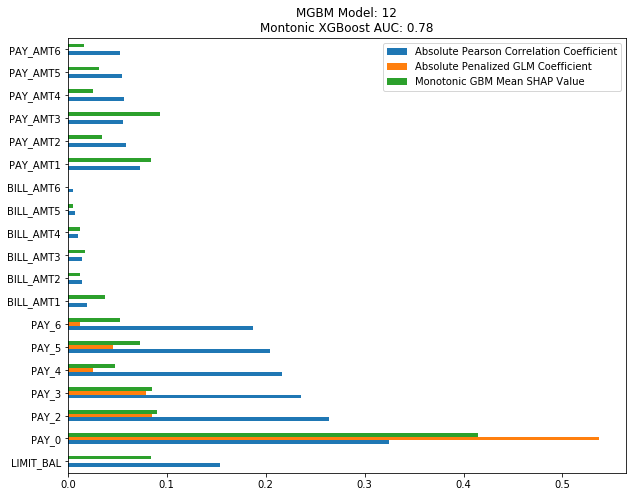

In [12]:
for j, frame in enumerate(corr_glm_mgbm_shap_coefs):
    
    # plot results
    auc_ = mgbm_models[j].auc(valid=True)
    title_ = 'MGBM Model: {j}\nMontonic XGBoost AUC: {auc:.2f}'.format(j=str(j), auc=auc_)     
    fig, ax_ = plt.subplots(figsize=(10, 8))
    _ = frame.plot(kind='barh', ax=ax_, title=title_)

In [13]:
mgbm_models[4]

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_5_sid_ad16_model_python_1579454096857_7618_model_18


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,6935.0,3.0,3.0,3.0,5.0,8.0,7.369565




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1363771986430037
RMSE: 0.3692928358945022
LogLoss: 0.4351274080189964
Mean Per-Class Error: 0.2915014965081477
AUC: 0.7716912455593035
pr_auc: 0.5472451346416678
Gini: 0.5433824911186069

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2197639481136088: 

,,0,1,Error,Rate
0,0,13482.0,2814.0,0.1727,(2814.0/16296.0)
1,1,1908.0,2742.0,0.4103,(1908.0/4650.0)
2,Total,15390.0,5556.0,0.2254,(4722.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.219764,0.537331,247.0
1,max f2,0.127441,0.630748,329.0
2,max f0point5,0.445082,0.583034,149.0
3,max accuracy,0.445082,0.821446,149.0
4,max precision,0.950247,1.000000,0.0
5,max recall,0.050609,1.000000,395.0
6,max specificity,0.950247,1.000000,0.0
7,max absolute_mcc,0.325289,0.413418,194.0
8,max min_per_class_accuracy,0.177539,0.698280,280.0
9,max mean_per_class_accuracy,0.219764,0.708499,247.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010074,0.813927,3.607883,3.607883,0.800948,0.843446,0.800948,0.843446,0.036344,0.036344,260.788259,260.788259
1,,2,0.020338,0.795575,3.519808,3.563432,0.781395,0.805153,0.791080,0.824119,0.036129,0.072473,251.980795,256.343177
2,,3,0.030316,0.763679,3.405328,3.511394,0.755981,0.783970,0.779528,0.810905,0.033978,0.106452,240.532798,251.139446
3,,4,0.040008,0.715138,3.261891,3.450954,0.724138,0.739815,0.766110,0.793684,0.031613,0.138065,226.189099,245.095388
4,,5,0.050081,0.664416,3.116869,3.383755,0.691943,0.686695,0.751192,0.772164,0.031398,0.169462,211.686898,238.375473
5,,6,0.100019,0.543384,2.859463,3.121984,0.634799,0.601794,0.693079,0.687101,0.142796,0.312258,185.946339,212.198445
6,,7,0.150005,0.366237,2.224293,2.822849,0.493792,0.446951,0.626671,0.607076,0.111183,0.423441,122.429306,182.284922
7,,8,0.205672,0.292765,1.595510,2.490659,0.354202,0.312777,0.552925,0.527422,0.088817,0.512258,59.551043,149.065864
8,,9,0.301251,0.196648,1.174504,2.073077,0.260739,0.234499,0.460222,0.434485,0.112258,0.624516,17.450421,107.307684
9,,10,0.400029,0.173817,0.864327,1.774604,0.191880,0.184844,0.393961,0.372842,0.085376,0.709892,-13.567284,77.460410




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13326994104124376
RMSE: 0.3650615578792757
LogLoss: 0.4278285715046422
Mean Per-Class Error: 0.2856607030196092
AUC: 0.7776380047998697
pr_auc: 0.5486322626112021
Gini: 0.5552760095997393

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27397344199105433: 

,,0,1,Error,Rate
0,0,6093.0,975.0,0.1379,(975.0/7068.0)
1,1,863.0,1123.0,0.4345,(863.0/1986.0)
2,Total,6956.0,2098.0,0.203,(1838.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.273973,0.549951,217.0
1,max f2,0.147835,0.634488,307.0
2,max f0point5,0.436620,0.590736,153.0
3,max accuracy,0.456963,0.825271,147.0
4,max precision,0.947069,1.000000,0.0
5,max recall,0.045106,1.000000,397.0
6,max specificity,0.947069,1.000000,0.0
7,max absolute_mcc,0.347246,0.429999,184.0
8,max min_per_class_accuracy,0.181585,0.709970,275.0
9,max mean_per_class_accuracy,0.230518,0.714339,240.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011155,0.815010,3.295055,3.295055,0.722772,0.839858,0.722772,0.839858,0.036757,0.036757,229.505549,229.505549
1,,2,0.020543,0.795575,3.700764,3.480460,0.811765,0.805631,0.763441,0.824217,0.034743,0.071501,270.076417,248.045999
2,,3,0.030042,0.783550,3.604721,3.519749,0.790698,0.792441,0.772059,0.814170,0.034240,0.105740,260.472142,251.974853
3,,4,0.040093,0.743192,3.005876,3.390927,0.659341,0.761335,0.743802,0.800925,0.030211,0.135952,200.587630,239.092657
4,,5,0.050033,0.697702,3.444512,3.401573,0.755556,0.723091,0.746137,0.785461,0.034240,0.170191,244.451158,240.157260
5,,6,0.101281,0.553193,3.104777,3.251394,0.681034,0.614736,0.713195,0.699075,0.159114,0.329305,210.477654,225.139444
6,,7,0.150320,0.383564,2.187046,2.904171,0.479730,0.466067,0.637032,0.623061,0.107251,0.436556,118.704581,190.417123
7,,8,0.200022,0.296915,1.580423,2.575244,0.346667,0.327817,0.564881,0.549698,0.078550,0.515106,58.042296,157.524427
8,,9,0.301303,0.203539,1.133514,2.090616,0.248637,0.250648,0.458578,0.449174,0.114804,0.629909,13.351366,109.061561
9,,10,0.403468,0.176970,0.961068,1.804595,0.210811,0.187190,0.395839,0.382836,0.098187,0.728097,-3.893198,80.459549




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-01-19 12:17:27,22.452 sec,0.0,0.415591,0.529427,0.500000,0.000000,1.000000,0.778001,0.413815,0.526105,0.500000,0.000000,1.000000,0.780649
1,,2020-01-19 12:17:27,22.464 sec,1.0,0.407822,0.511864,0.716131,0.534717,3.474912,0.236370,0.405538,0.507496,0.726731,0.537125,3.444264,0.187652
2,,2020-01-19 12:17:27,22.474 sec,2.0,0.401483,0.498746,0.744646,0.532172,3.529706,0.228731,0.398808,0.493698,0.752909,0.534588,3.422307,0.232825
3,,2020-01-19 12:17:27,22.486 sec,3.0,0.396471,0.489013,0.748189,0.535621,3.529706,0.228636,0.393394,0.483273,0.756448,0.535692,3.422307,0.214491
4,,2020-01-19 12:17:27,22.497 sec,4.0,0.392442,0.481430,0.750121,0.535358,3.529706,0.210780,0.389030,0.475135,0.758511,0.536095,3.422307,0.217915
5,,2020-01-19 12:17:27,22.508 sec,5.0,0.389141,0.475375,0.750058,0.535198,3.529706,0.245059,0.385453,0.468630,0.758505,0.535659,3.422307,0.214270
6,,2020-01-19 12:17:27,22.519 sec,6.0,0.386399,0.470332,0.756986,0.535024,3.529706,0.243961,0.382447,0.463157,0.764722,0.536039,3.422307,0.229843
7,,2020-01-19 12:17:27,22.530 sec,7.0,0.384191,0.466316,0.757005,0.535418,3.529706,0.243961,0.380045,0.458834,0.764634,0.536411,3.422307,0.220013
8,,2020-01-19 12:17:27,22.541 sec,8.0,0.382341,0.462760,0.761106,0.540176,3.514359,0.247446,0.378063,0.455049,0.770340,0.542043,3.457524,0.204330
9,,2020-01-19 12:17:27,22.552 sec,9.0,0.380701,0.459589,0.762515,0.540880,3.518279,0.235654,0.376184,0.451464,0.772358,0.543522,3.457524,0.223548



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,PAY_0,2794.444824,1.000000,0.693347
1,PAY_2,307.237366,0.109946,0.076231
2,PAY_3,215.152893,0.076993,0.053383
3,PAY_4,155.434448,0.055623,0.038566
4,PAY_AMT1,127.986313,0.045800,0.031755
5,PAY_5,127.538628,0.045640,0.031644
6,PAY_6,102.351601,0.036627,0.025395
7,LIMIT_BAL,82.432350,0.029499,0.020453
8,PAY_AMT2,58.934135,0.021090,0.014623
9,PAY_AMT4,58.858047,0.021063,0.014604


## 4. Calculating partial dependence and ICE to validate and explain monotonic behavior

#### Function for calculating partial dependence

In [14]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: 
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        # modify max and by 
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))    

    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    tframe = frame.copy(deep=True)
    tframe.loc[:, xs] = bins[0]
    for j, _ in enumerate(bins): 
        if j+1 < len(bins): 
            frame.loc[:, xs] = bins[j+1]
            tframe = tframe.append(frame, ignore_index=True)

    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache        
            
    # model predictions
    tframe['partial_dependence'] = model.predict(h2o.H2OFrame(tframe))['p1'].as_data_frame()
    
    return pd.DataFrame(tframe[[xs, 'partial_dependence']].groupby([xs]).mean()).reset_index()


#### Calculate partial dependence for the most important input variables in the GBM
The partial dependence for `LIMIT_BAL` can be seen to decrease as credit balance limits increase. This finding is aligned with expectations that the model predictions will be monotonically decreasing with increasing `LIMIT_BAL` and parsimonious with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [30]:
par_dep_glm_PAY_0 = par_dep('PAY_0', test, best_glm)         # calculate partial dependence for PAY_0 for glm
par_dep_mgbm_PAY_0 = par_dep('PAY_0', test, mgbm_models[3])   # calculate partial dependence for PAY_0 for glm

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
par_dep_PAY_0 = pd.concat([par_dep_glm_PAY_0, par_dep_mgbm_PAY_0['partial_dependence']], axis=1)
par_dep_PAY_0.columns = ['PAY_0', 'partial_dependence_glm', 'partial_dependence_mgbm']
par_dep_PAY_0

,PAY_0,partial_dependence_glm,partial_dependence_mgbm
0,-2.000,0.082280,0.172167
1,-1.475,0.105874,0.172167
2,-0.950,0.135136,0.172167
3,-0.425,0.170804,0.172167
4,0.100,0.213387,0.172922
5,0.625,0.263012,0.252675
6,1.150,0.319262,0.252675
7,1.675,0.381088,0.536813
8,2.200,0.446815,0.536813
9,2.725,0.514284,0.538050


#### Helper function for finding percentiles of predictions

In [47]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of yhat in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [48]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True),
                       mgbm_models[3].predict(h2o.H2OFrame(test))['p1'].as_data_frame()],
                      axis=1)

yhat_test = yhat_test.rename(columns={'p1':'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


{0: 14136,
 99: 17863,
 10: 9632,
 20: 29179,
 30: 25974,
 40: 5795,
 50: 9033,
 60: 7620,
 70: 9808,
 80: 15816,
 90: 16549}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [49]:
# retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
#bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
#bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(percentile_dict[i])][X],  
                                    mgbm_models[3], 
                                    bins=bins_PAY_0)['partial_dependence']
    
    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    #par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
    #                                      test[test['ID'] == int(percentile_dict[i])][X], 
    #                                      xgb_model, 
    #                                      bins=bins_LIMIT_BAL)['partial_dependence']
    


    # ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    #par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1', 
    #                                      test[test['ID'] == int(percentile_dict[i])][X],  
    #                                      xgb_model, 
    #                                      bins=bins_BILL_AMT1)['partial_dependence']

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |███████████

#### Display partial dependence and ICE for `LIMIT_BAL`
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for `DEFAULT_NEXT_MONTH` and at the values of `LIMIT_BAL` used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting `LIMIT_BAL` to the value of `LIMIT_BAL` at right. Notice that monotonic decreasing prediction behavior for `LIMIT_BAL` holds at each displayed percentile of predicted `DEFAULT_NEXT_MONTH`, helping to validate that the trained GBM predictions are monotonic for `LIMIT_BAL`.

In [50]:
par_dep_PAY_0

,PAY_0,partial_dependence_glm,partial_dependence_mgbm,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.000,0.082280,0.172167,0.045271,0.092901,0.102704,0.115331,0.132731,0.152190,0.173656,0.200836,0.184710,0.463408,0.739221
1,-1.475,0.105874,0.172167,0.045271,0.092901,0.102704,0.115331,0.132731,0.152190,0.173656,0.200836,0.184710,0.463408,0.739221
2,-0.950,0.135136,0.172167,0.045271,0.092901,0.102704,0.115331,0.132731,0.152190,0.173656,0.200836,0.184710,0.463408,0.739221
3,-0.425,0.170804,0.172167,0.045271,0.092901,0.102704,0.115331,0.132731,0.152190,0.173656,0.200836,0.184710,0.463408,0.739221
4,0.100,0.213387,0.172922,0.045271,0.092901,0.102704,0.115331,0.132731,0.152190,0.173656,0.200836,0.184710,0.469081,0.743592
5,0.625,0.263012,0.252675,0.074376,0.149459,0.171548,0.180936,0.215669,0.235490,0.270928,0.303154,0.291498,0.551763,0.797646
6,1.150,0.319262,0.252675,0.074376,0.149459,0.171548,0.180936,0.215669,0.235490,0.270928,0.303154,0.291498,0.551763,0.797646
7,1.675,0.381088,0.536813,0.274099,0.488263,0.403152,0.527409,0.609300,0.557524,0.598177,0.482138,0.460194,0.800863,0.933519
8,2.200,0.446815,0.536813,0.274099,0.488263,0.403152,0.527409,0.609300,0.557524,0.598177,0.482138,0.460194,0.800863,0.933519
9,2.725,0.514284,0.538050,0.274099,0.488263,0.403152,0.527409,0.609300,0.557524,0.598177,0.482138,0.460194,0.810801,0.937355


## 5. Plotting partial dependence and ICE to validate and explain monotonic behavior

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the three most important variables in the GBM: `PAY_0`, `LIMIT_BAL`, and `BILL_AMT1`.

In [55]:
def plot_par_dep_ICE(xs, par_dep_frame, ax=None):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    Conditionally uses user-defined axes, ticks, and labels for grouped subplots.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        ax: Matplotlib axis object to use, default None.         
    
    """
    
    # for standalone plotting
    if ax is None:
        
        # initialize figure and axis
        fig, ax = plt.subplots()
        
        # plot ICE
        par_dep_frame.drop('partial_dependence_mgbm', axis=1).plot(x=xs, 
                                                              colormap='coolwarm', 
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence_mgbm',
                           color='grey', 
                           linewidth=3, 
                           ax=ax)
    
    # for grouped subplots 
    else: 
        
        # plot ICE
        par_dep_frame.drop('partial_dependence_mgbm', axis=1).plot(x=xs, 
                                                              colormap='gnuplot',
                                                              ax=ax)
        # overlay partial dependence, annotate plot
        par_dep_frame.plot(title='Partial Dependence with ICE',
                           x=xs, 
                           y='partial_dependence_mgbm',
                           color='red', 
                           linewidth=3, 
                           ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

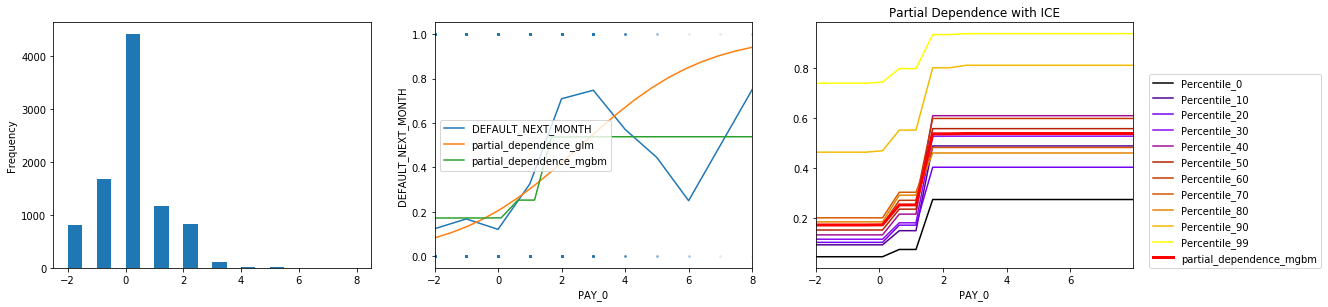

In [86]:
# setup 3-way figure
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2.5, wspace=0.2)
   
# histogram 
test['PAY_0'].plot(kind='hist', bins=20, ax=ax0)
 
#  comparison of partial dependence
_ = test[['PAY_0', y]].groupby(by='PAY_0').mean().plot(kind='line', ax=ax1)
_ = test[['PAY_0', y]].plot(kind='scatter', x='PAY_0', y=y, ax=ax1, s=3, alpha=0.1)
_ = par_dep_PAY_0[['PAY_0', 'partial_dependence_glm','partial_dependence_mgbm']].plot(kind='line', x='PAY_0', ax=ax1, )

# partial dependence and ICE #
plot_par_dep_ICE('PAY_0', par_dep_PAY_0.drop(['partial_dependence_glm'], 
                                             axis=1), 
                  ax2)

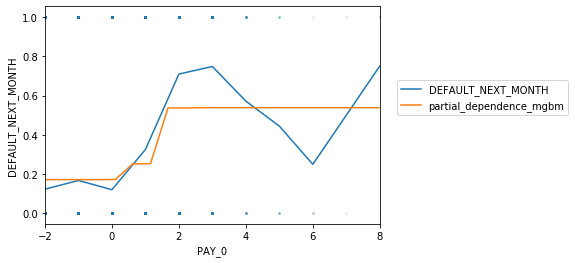

In [89]:
fig, ax = plt.subplots()
#  comparison of partial dependence
_ = test[['PAY_0', y]].groupby(by='PAY_0').mean().plot(kind='line', ax=ax)
_ = test[['PAY_0', y]].plot(kind='scatter', x='PAY_0', y=y, ax=ax, s=3, alpha=0.1)
_ = par_dep_PAY_0[['PAY_0', 'partial_dependence_mgbm']].plot(kind='line', x='PAY_0', ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0.5),
               loc=3, 
               borderaxespad=0.)

#### Partial dependence and ICE plot for `LIMIT_BAL`
The monotonic prediction behavior displayed in the partial dependence, and ICE tables for `LIMIT_BAL` is also visible in this plot. Monotonic decreasing behavior is evident at every percentile of predictions for `DEFAULT_NEXT_MONTH`. Most percentiles of predictions show that sharper decreases in probability of default occur when `LIMIT_BAL` increases just slightly from its lowest values in the test set. However, for the custumers that are most likely to default according to the GBM model, no increase in `LIMIT_BAL` has a strong impact on probabilitiy of default. As mentioned previously, the displayed relationship between credit balance limits and probablility of default is not uncommon in credit lending. As can be seen from the displayed histogram, above ~$NT 500,000 prediction behavior may have been learned from extremely small samples of data. 

#### Partial dependence and ICE plot for `PAY_0`
Monotonic increasing prediction behavior for `PAY_0` is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the red partial dependence curve. The largest jump in predicted probability appears to occur at `PAY_0 = 2`, or when a customer becomes two months late on their most recent payment. Above `PAY_0 = 3` there are few examples from which the model could learn.

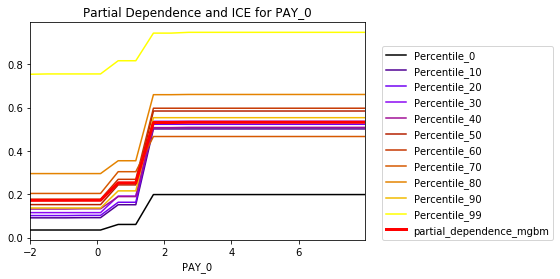

In [28]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) # plot partial dependence and ICE for PAY_0

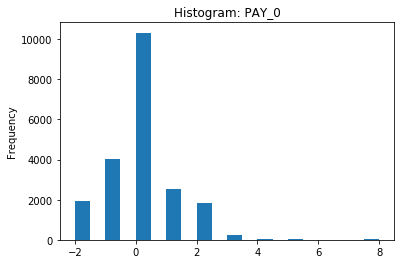

In [29]:
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0')

#### Partial dependence and ICE plot for `BILL_AMT1`
Monotonic decreasing prediction behavior for `BILL_AMT1` is also displayed for all percentiles. This mild decrease in probability of default as most recent bill amount increases could be related to wealthier, big-spending customers taking on more debt but also being able to pay it off reliably. Also, customers with negative bills are more likely to default, potentially indicating charge-offs are being recorded as negative bills. In a mission-critical situation, this issue would require more debugging. Also predictions below \$ NT 0 and above \$ NT 400,000 are based on very little training data.

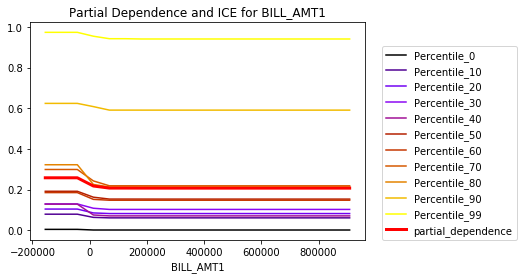

In [22]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) # plot partial dependence and ICE for BILL_AMT1

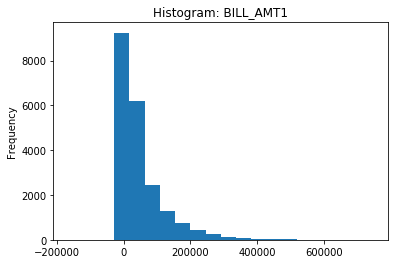

In [23]:
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: BILL_AMT1')

## 6. Generate reason codes using the Shapley method 
Now that the monotonic behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also *always* sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the `pred_contribs` parameter to `predict()`, but the `shap` package is also available for other types of models: https://github.com/slundberg/shap. 

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

To find the index corresponding to a particular row of interest later, the index of the `test` DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the `test` DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [24]:
test.reset_index(drop=True, inplace=True)

#### Select most risky customer in test data
One person who might be of immediate interest is the most likely to default customer in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

In [25]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

#### Create a Pandas DataFrame of Shapley values for riskiest customer
The most interesting Shapley values are probably those that push this customer's probability of default higher, i.e. the highest positive Shapley values. Those values are plotted below.

In [26]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

In [27]:
s_df

,Reason Codes
PAY_0,1.526435
PAY_5,0.511360
PAY_6,0.328183
PAY_2,0.289542
LIMIT_BAL,0.287896
PAY_4,0.227838
AGE,0.225641
BILL_AMT1,0.197412
PAY_3,0.178575
MARRIAGE,0.171177


#### Plot top local contributions as reason codes

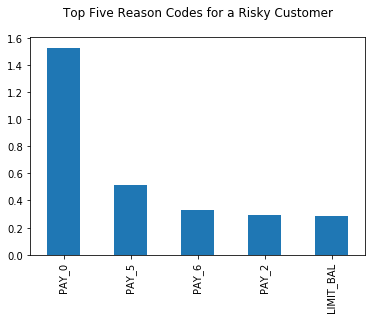

In [28]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

For the customer in the test dataset that the GBM predicts as most likely to default, the most important input variables in the prediction are, in descending order, `PAY_0`, `PAY_5`, `PAY_6`, `PAY_2`, and `LIMIT_BAL`.

#### Display customer in question 

The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 3 months late and her payment for 6 months and 5 months previous were 7 months late. Also her credit limit was extremely low, so it's logical that these factors would weigh heavily into the model's prediction for default for this customer.

In [29]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
5399,17757,10000,2,3,1,51,3,2,2,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1


To generate reason codes for the model's decision, the locally important variable and its value are used together. If this customer was denied future credit based on this model and data, the top five Shapley-based reason codes for the automated decision would be:

1. Most recent payment is 3 months delayed.
2. 5th most recent payment is 7 months delayed.
3. 6th most recent payment is 7 months delayed.
4. 2nd most recent payment is 2 months delayed.
5. Credit limit is too low: 10,000 $NT.

(Of course, credit limits are set by the lender and are used to price-in risk to credit decisions, so using credit limits as reason codes or even in a probability of default model is likely questionable. However, in this small, example data set all input columns were used to generate a better model fit. For a slightly more careful treatment of gradient boosting in the context of credit scoring, please see: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/dia.ipynb)

#### Summary

In this notebook, a highly transparent, nonlinear, monotonic GBM classifier was trained to predict credit card defaults and the monotonic behavior of the classifier was analyzed and validated. To do so, Pearson correlation between each input and the target was used to determine the direction for monotonicity constraints for each input variable in the XGBoost classifier. GBM variable importance, partial dependence, and ICE were calculated, plotted, and compared to one another, domain knowledge, and reasonable expectations. Shapley values were then used to explain the model predictions for the single most risky customer in the test set. These techniques should generalize well for many types of business and research problems, enabling you to train a monotonic GBM model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators. 